# <font color='FFAD00'>Time Series Forecasting using XGBoost</font>

In [54]:
import numpy as np
import pandas as pd
from xgboost import plot_importance, plot_tree
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('tableau-colorblind10')

In [55]:
df = pd.read_csv('WTI_Minute_Data_2018_2023.csv')
df["Date"] = pd.to_datetime(df["Date"])
df = df.iloc[: , 1:]
df = df.set_index('Date')
li = range(0, len(df), 100)
df = df.iloc[li, :][:5000]
df=df.iloc[:, 1:]
df.head()

,Close
Date,
2018-01-01 18:00:00,60.24
2018-01-01 20:44:00,60.59
2018-01-01 23:13:00,60.59
2018-01-02 02:22:00,60.66
2018-01-02 04:08:00,60.45


### <font color='FFAD00'>Data Pre-Processing</font>

In [56]:
df['hour'] = df.index.hour
df['minute'] = df.index.minute
df['dayofweek'] = df.index.dayofweek
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['year'] = df.index.year
df['dayofyear'] = df.index.dayofyear
df['dayofmonth'] = df.index.day
df['weekofyear'] = df.index.isocalendar().week

### <font color='FFAD00'>Train-Test Split</font>

In [57]:
df

,Close,hour,minute,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,
2018-01-01 18:00:00,60.240,18,0,0,1,1,2018,1,1,1
2018-01-01 20:44:00,60.590,20,44,0,1,1,2018,1,1,1
2018-01-01 23:13:00,60.590,23,13,0,1,1,2018,1,1,1
2018-01-02 02:22:00,60.660,2,22,1,1,1,2018,2,2,1
2018-01-02 04:08:00,60.450,4,8,1,1,1,2018,2,2,1
...,...,...,...,...,...,...,...,...,...,...
2019-07-21 22:41:00,56.245,22,41,6,3,7,2019,202,21,29
2019-07-22 00:52:00,56.175,0,52,0,3,7,2019,203,22,30
2019-07-22 02:44:00,56.315,2,44,0,3,7,2019,203,22,30


In [60]:
len(df)

5000

In [61]:
df_train=df[df['year']<2019]
X_train=df_train.drop(['Close'],axis=1)
y_train=df_train['Close']

In [62]:
X_train

,hour,minute,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,
2018-01-01 18:00:00,18,0,0,1,1,2018,1,1,1
2018-01-01 20:44:00,20,44,0,1,1,2018,1,1,1
2018-01-01 23:13:00,23,13,0,1,1,2018,1,1,1
2018-01-02 02:22:00,2,22,1,1,1,2018,2,2,1
2018-01-02 04:08:00,4,8,1,1,1,2018,2,2,1
...,...,...,...,...,...,...,...,...,...
2018-12-31 08:47:00,8,47,0,4,12,2018,365,31,1
2018-12-31 10:27:00,10,27,0,4,12,2018,365,31,1
2018-12-31 12:07:00,12,7,0,4,12,2018,365,31,1


In [63]:
df_test=df[df['year']>=2019]
X_test=df_test.drop(['Close'],axis=1)
y_test=df_test['Close']

In [64]:
X_test

,hour,minute,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,
2019-01-01 19:07:00,19,7,1,1,1,2019,1,1,1
2019-01-01 20:50:00,20,50,1,1,1,2019,1,1,1
2019-01-01 22:30:00,22,30,1,1,1,2019,1,1,1
2019-01-02 00:14:00,0,14,2,1,1,2019,2,2,1
2019-01-02 01:55:00,1,55,2,1,1,2019,2,2,1
...,...,...,...,...,...,...,...,...,...
2019-07-21 22:41:00,22,41,6,3,7,2019,202,21,29
2019-07-22 00:52:00,0,52,0,3,7,2019,203,22,30
2019-07-22 02:44:00,2,44,0,3,7,2019,203,22,30


In [65]:
df_test.head(5)

,Close,hour,minute,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,
2019-01-01 19:07:00,45.855,19,7,1,1,1,2019,1,1,1
2019-01-01 20:50:00,45.405,20,50,1,1,1,2019,1,1,1
2019-01-01 22:30:00,45.275,22,30,1,1,1,2019,1,1,1
2019-01-02 00:14:00,45.035,0,14,2,1,1,2019,2,2,1
2019-01-02 01:55:00,44.800,1,55,2,1,1,2019,2,2,1


In [66]:
X_train.shape,X_test.shape

((3182, 9), (1818, 9))

### <font color='FFAD00'>Calling the XGBoost Regressor</font>

In [67]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)


In [68]:
yhat

array([60.28369 , 60.963043, 60.561954, ..., 68.1135  , 68.19263 ,
       68.70198 ], dtype=float32)

In [69]:
y_test

Date
2019-01-01 19:07:00    45.855
2019-01-01 20:50:00    45.405
2019-01-01 22:30:00    45.275
2019-01-02 00:14:00    45.035
2019-01-02 01:55:00    44.800
                        ...  
2019-07-21 22:41:00    56.245
2019-07-22 00:52:00    56.175
2019-07-22 02:44:00    56.315
2019-07-22 04:24:00    56.815
2019-07-22 06:04:00    56.635
Name: Close, Length: 1818, dtype: float64

In [70]:
from sklearn.metrics import mean_squared_error as MSE
rmse = np.sqrt(MSE(y_test, yhat))
print("RMSE : % f" %(rmse))

RMSE :  9.613689


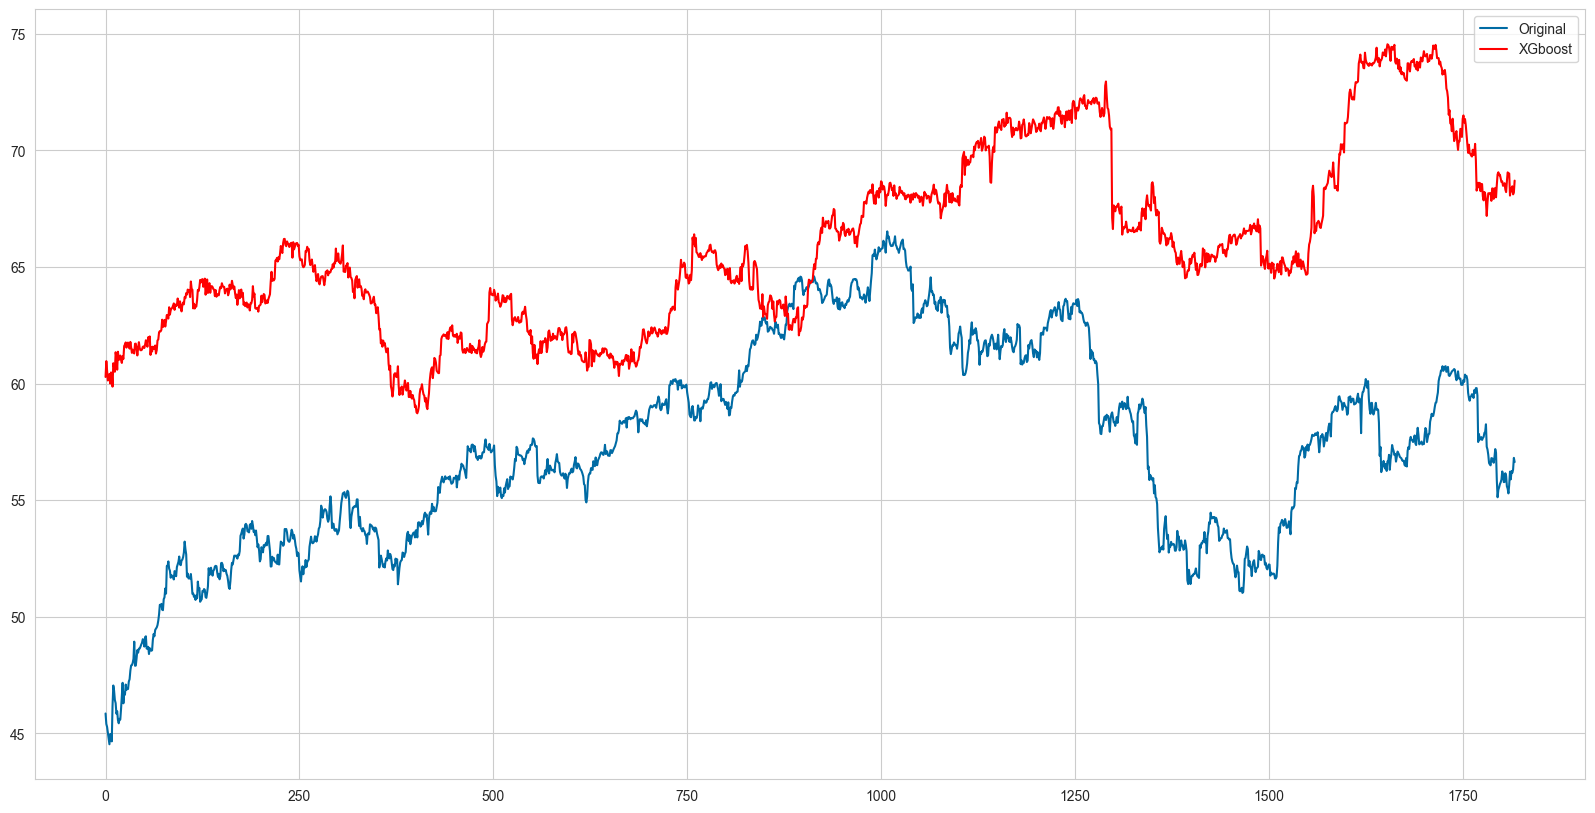

In [71]:
plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()